In [764]:
from rake_nltk import Rake
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import random




### Function to actually recommend similar foods
similarity_thereshold = 0.5
def recommend(name,data,cosine_sim):
    indices = pd.Series(data['name'])
    recommended_items = []
    
    if indices[indices == name].any():
        idx = indices[indices == name].index[0]
        score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
        count = score_series.apply(lambda x : x > similarity_thereshold).sum()
        top_indices = list(score_series.iloc[1 : count+1].index)
        print('Total similar foods count: ', count)

        for i in top_indices:
            recommended_items.append(data.iloc[i]['name'])
        return list(set(recommended_items))
    else:
        print('Oops, Item Not Found :(') 

### Fuction to recommend based on the highest order item
def historical_recommend(userid, orders, items, cosine_sim):
    items_order_by_user = orders[orders.userid == userid].itemid.value_counts()
    highest_order_item = items_order_by_user.idxmax()

    print(highest_order_item)
    item_name = items[items.id == highest_order_item].name.values[0]
    print('Higest order food is: ',item_name)

    return recommend(item_name,food_items,cosine_sim)     

In [667]:
orders = pd.read_csv('../data/full_data.csv',low_memory=False)
orders.head(3)

,OrderId,UserId,RestaurantId,Date,Rating,Comments,Address,Count,ItemId,Price,ViewCount,Name,Description,SearchVector,Type
0,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,211,15.0,0.0,Tableside Spinach Salad,NaN,'almond':8 'babi':4 'bacon':11 'jack':10 'mont...,Main
1,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,218,27.0,0.0,King Crab,NaN,'blanc':9 'buerr':8 'caper':7 'char':3 'chilli...,Main
2,293,4,121,2020-05-13 01:20:59.267256,NaN,NaN,NaN,1,440,14.0,1097.0,Joojeh Kabab With Rice,One skewer of chicken breast marinated with yo...,'bbq':14 'chicken':11 'joojeh':1 'juic':9 'kab...,Main


In [669]:
food_items = pd.read_csv('../data/itemsInfo_full.csv',low_memory=False)
food_items.head()

,Id,Price,ViewCount,Name,Description,TagsString,SearchVector,Type
0,8345,0.9,0,Cookie,Freshly baked cookies. One order comes with on...,NaN,'cooki':1,Main
1,8346,7.0,0,12 Cookies,Freshly baked cookies. One order comes with tw...,NaN,'12':1 'cooki':2,Main
2,2046,18.0,0,Sausage Hash-n-eggs,NaN,NaN,'egg':5 'hash':3 'hash-n-egg':2 'n':4 'sausag':1,Main
3,2047,18.0,0,Ham Hash-n-eggs,NaN,NaN,'egg':5 'ham':1 'hash':3 'hash-n-egg':2 'n':4,Main
4,2048,18.0,0,Debakon Hash-n-eggs,DeBakon with hash-n-eggs.,NaN,'debakon':1 'egg':5 'hash':3 'hash-n-egg':2 'n':4,Main


In [670]:
food_items.columns = [c.lower() for c in food_items.columns]
orders.columns = [c.lower() for c in orders.columns]

In [671]:
food_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68100 entries, 0 to 68099
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            68100 non-null  int64  
 1   price         67938 non-null  float64
 2   viewcount     68100 non-null  int64  
 3   name          68082 non-null  object 
 4   description   48742 non-null  object 
 5   tagsstring    34591 non-null  object 
 6   searchvector  68081 non-null  object 
 7   type          68082 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 4.2+ MB


In [672]:
food_items.description.isna().sum()

19358

In [212]:
#items = items[~items.description.isna()].reset_index(drop=True)

In [673]:
food_items.description

0        Freshly baked cookies. One order comes with on...
1        Freshly baked cookies. One order comes with tw...
2                                                      NaN
3                                                      NaN
4                                DeBakon with hash-n-eggs.
                               ...                        
68095                                                  NaN
68096                                                  NaN
68097    White radish, carrot, mini cucumber, Japanese ...
68098                                                  NaN
68099                                                  NaN
Name: description, Length: 68100, dtype: object

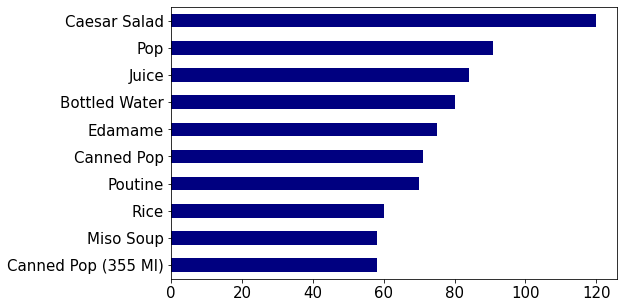

In [674]:
food_items['name'].value_counts()[0:10].plot(kind ='barh', figsize=[8,5], fontsize=15, color='navy').invert_yaxis()


In [218]:
#items = items[~(items.description.duplicated() & items.name)].reset_index(drop=True)

In [675]:
food_items.drop_duplicates(subset = ['name','description'], keep = 'first', inplace = True)
food_items.reset_index(drop=True, inplace=True);

In [676]:
food_items.index

RangeIndex(start=0, stop=49316, step=1)

In [677]:
def tokenize(text):
    r = Rake()
    r.extract_keywords_from_text(text.lower().replace('nan',' '))
    return r.get_ranked_phrases()[0:10]


In [678]:
food_items.columns

Index(['id', 'price', 'viewcount', 'name', 'description', 'tagsstring',
       'searchvector', 'type'],
      dtype='object')

In [679]:
food_items['bow'] = food_items['name'].map(str) + ',' + food_items['description'].map(str)


In [680]:
food_items['tokenized'] = food_items.bow.apply(tokenize)

In [684]:
food_items['tokenized'].iloc[100]

['chocolate chunk cookie', '210 cals ),']

In [685]:
food_items['tokens'] = food_items.tokenized.apply(lambda x: ','.join(map(str,x)))

In [686]:
food_items['tokens'].iloc[100]

'chocolate chunk cookie,210 cals ),'

In [687]:
food_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49316 entries, 0 to 49315
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            49316 non-null  int64  
 1   price         49167 non-null  float64
 2   viewcount     49316 non-null  int64  
 3   name          49315 non-null  object 
 4   description   35456 non-null  object 
 5   tagsstring    26058 non-null  object 
 6   searchvector  49314 non-null  object 
 7   type          49315 non-null  object 
 8   bow           49316 non-null  object 
 9   tokenized     49316 non-null  object 
 10  tokens        49316 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 4.1+ MB


In [688]:
# vectorise the tokens
counter = CountVectorizer()
count_matrix = counter.fit_transform(food_items.tokens)

In [689]:
cosine_sim = cosine_similarity(count_matrix)
print(cosine_sim)

[[1.         0.85280287 0.         ... 0.         0.         0.        ]
 [0.85280287 1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.05634362]
 [0.         0.         0.         ... 0.         0.05634362 1.        ]]


### Sample recommendation based on similar food

In [770]:
sample_item = food_items.iloc[100]
sample_name = sample_item['name']
sample_desc = sample_item['description']
print('The item name is {}\nThe description is:{}'.format(sample_name,sample_desc))

The item name is Chocolate Chunk Cookie (210 Cals)
The description is:nan


In [771]:
recommend(sample_name,food_items,cosine_sim)

Total similar foods count:  8


['Chocolate Chunk Cookie (large)',
 'Chocolate Peanut Butter Cookie',
 'Double Chocolate Chunk',
 'Chocolate Chunk Cookie',
 'Chocolate Chip Cookie',
 "Chocolate Chip With M&m's® Candies Cookie (210 Cals)",
 'Cookie',
 'Chocolate Pecan Cookie']

### Now we will recommend based on the user history and the similar food to highest order item

In [772]:
user_ids = list(set(orders.userid))
sample_user = orders[orders.userid == random.choice(user_ids)].userid.values[0]
sample_user

4577

In [773]:
historical_recommend(sample_user,orders,food_items,cosine_sim)


81558
Higest order food is:  Fish And Chips (G)
Total similar foods count:  25


['Fish And Chips',
 'Pacific Cod (2 Pcs) And Chips',
 'Cod & Chips',
 'Fish N’ Chips',
 '2 Piece Fish And Chips',
 'Japanese-style Fish And Chips',
 'Tartar Sauce',
 'Pacific Cod And Chips',
 '4. Homestyle Fish And Chips With Coleslaw',
 'Fish (1 Pc) And Chips',
 'London-style Fish And Chips',
 'Fish (3 Pcs) And Chips Combo',
 'Fish Burger',
 'Cod And Chips (2 Pcs)']

In [751]:
food_items.head()

,id,price,viewcount,name,description,tagsstring,searchvector,type,bow,tokenized,tokens
0,8345,0.9,0,Cookie,Freshly baked cookies. One order comes with on...,NaN,'cooki':1,Main,"Cookie,Freshly baked cookies. One order comes ...","[230 cals per cookie, freshly baked cookies, s...","230 cals per cookie,freshly baked cookies,swee..."
1,8346,7.0,0,12 Cookies,Freshly baked cookies. One order comes with tw...,NaN,'12':1 'cooki':2,Main,"12 Cookies,Freshly baked cookies. One order co...","[230 cals per cookie, sweet assorted cookie, o...","230 cals per cookie,sweet assorted cookie,one ..."
2,2046,18.0,0,Sausage Hash-n-eggs,NaN,NaN,'egg':5 'hash':3 'hash-n-egg':2 'n':4 'sausag':1,Main,"Sausage Hash-n-eggs,nan","[sausage hash, n, eggs]","sausage hash,n,eggs"
3,2047,18.0,0,Ham Hash-n-eggs,NaN,NaN,'egg':5 'ham':1 'hash':3 'hash-n-egg':2 'n':4,Main,"Ham Hash-n-eggs,nan","[ham hash, n, eggs]","ham hash,n,eggs"
4,2048,18.0,0,Debakon Hash-n-eggs,DeBakon with hash-n-eggs.,NaN,'debakon':1 'egg':5 'hash':3 'hash-n-egg':2 'n':4,Main,"Debakon Hash-n-eggs,DeBakon with hash-n-eggs.","[debakon hash, hash, debakon, n, n, eggs, eggs]","debakon hash,hash,debakon,n,n,eggs,eggs"


In [752]:
orders.head()

,orderid,userid,restaurantid,date,rating,comments,address,count,itemid,price,viewcount,name,description,searchvector,type
0,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,211,15.0,0.0,Tableside Spinach Salad,NaN,'almond':8 'babi':4 'bacon':11 'jack':10 'mont...,Main
1,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,218,27.0,0.0,King Crab,NaN,'blanc':9 'buerr':8 'caper':7 'char':3 'chilli...,Main
2,293,4,121,2020-05-13 01:20:59.267256,NaN,NaN,NaN,1,440,14.0,1097.0,Joojeh Kabab With Rice,One skewer of chicken breast marinated with yo...,'bbq':14 'chicken':11 'joojeh':1 'juic':9 'kab...,Main
3,294,3,121,2020-05-13 17:34:35.519326,NaN,NaN,NaN,1,455,1.5,9.0,Regular Coffee,NaN,'coffe':2 'regular':1,Drink
4,297,142,121,2020-05-14 00:08:48.756423,NaN,NaN,NaN,1,540,9.9,485.0,Kashk Bademjan,"Barbequed eggplant, lentils, fried onions, gar...",'bademjan':2 'bbq':8 'egg':10 'eggplant':6 'ga...,Main


In [749]:
items_ordered = pd.merge(
    orders,
    food_items,
    left_on='itemid',
    right_on='id',
    how='left'
)

In [750]:
items_ordered.head()

,orderid,userid,restaurantid,date,rating,comments,address,count,itemid,price_x,...,price_y,viewcount_y,name_y,description_y,tagsstring,searchvector_y,type_y,bow,tokenized,tokens
0,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,211,15.0,...,15.0,0.0,Tableside Spinach Salad,NaN,Baby Spinach Mushrooms Toasted Almonds Monter...,'almond':8 'babi':4 'bacon':11 'jack':10 'mont...,Main,"Tableside Spinach Salad,nan",[tableside spinach salad],tableside spinach salad
1,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,218,27.0,...,27.0,0.0,King Crab,NaN,Charred Lemon Serrano Chillies Caper Buerre B...,'blanc':9 'buerr':8 'caper':7 'char':3 'chilli...,Main,"King Crab,nan",[king crab],king crab
2,293,4,121,2020-05-13 01:20:59.267256,NaN,NaN,NaN,1,440,14.0,...,14.0,1097.0,Joojeh Kabab With Rice,One skewer of chicken breast marinated with yo...,Olive Oil Saffron Lemon Juice Yogurt Chicken ...,'bbq':14 'chicken':11 'joojeh':1 'juic':9 'kab...,Main,"Joojeh Kabab With Rice,One skewer of chicken b...","[chicken breast marinated, one skewer, olive o...","chicken breast marinated,one skewer,olive oil,..."
3,294,3,121,2020-05-13 17:34:35.519326,NaN,NaN,NaN,1,455,1.5,...,1.5,9.0,Regular Coffee,NaN,NaN,'coffe':2 'regular':1,Drink,"Regular Coffee,nan",[regular coffee],regular coffee
4,297,142,121,2020-05-14 00:08:48.756423,NaN,NaN,NaN,1,540,9.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
items_ordered = items_ordered[['orderid','restaurantid','userid','itemid','name']]

In [31]:
orders = orders[orders.restaurantid == 1029]

In [32]:
orders_count = counter.transform(orders.name)

In [33]:
orders_count = orders_count.toarray()

In [34]:
orders_count.shape

(16451, 6365)

In [ ]:
kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 1000,
        "random_state": 42,}


# making a list of sum of squared errors for different cluster amounts (1-19)

sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(orders_count)
    sse.append(kmeans.inertia_)

sse

[53703.979675637864,
 48334.07746095134,
 45285.21622746169,
 44571.756469531945,
 42207.35414237622,
 41469.26686794766,
 39215.23208438727,
 37960.587284991896,
 36883.30144744937,
 32856.93499369147,
 30611.300289741634,
 29466.254928579925,
 27029.486289573088,
 27023.431975510517,
 26834.849241737476,
 25347.300501888967,
 25146.05534633927,
 24688.501800025333,
 24464.667261687926]

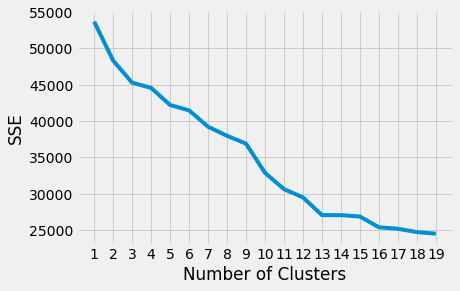

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [39]:
km = KMeans(n_clusters=20)
X_clustered=km.fit_predict(orders_count)


In [40]:
orders['clusters'] = X_clustered

In [41]:
orders.head()

,orderid,restaurantid,userid,itemid,name,clusters
68,373,1029,215,82659,Shoestring Fries (G),3
71,379,1029,165,81580,Popina Bottled Water,16
72,380,1029,110,81580,Popina Bottled Water,16
73,381,1029,110,81580,Popina Bottled Water,16
74,382,1029,122,81555,Crispy Free Run Chicken Sandwich,2


In [43]:
orders.clusters.value_counts()

13    2476
3     2390
2     1399
0     1371
8     1045
1      906
12     767
5      552
11     548
9      541
4      520
15     508
6      500
14     465
10     453
7      452
18     420
16     396
19     381
17     361
Name: clusters, dtype: int64

In [47]:
import matplotlib.pyplot as plt

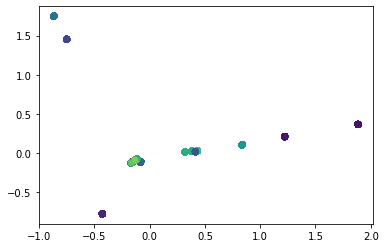

In [48]:
model= cluster.KMeans(n_clusters=20)
# Call a fit_predict() on X 
cluster_assignments = model.fit_predict(orders_count)

# Use decomposition.PCA, and pass n_components=2 as parameter
pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(orders_count))
plt.scatter(pc1, pc2, c=cluster_assignments.tolist())

In [55]:
filtered_label0 = orders[X_clustered == 13]
filtered_label0[:]

,orderid,restaurantid,userid,itemid,name,clusters
157,422,1029,230,82673,Pino Gris White 5oz,13
163,424,1029,230,82672,Merlot Red 5oz,13
165,425,1029,230,82660,"Mayhem, Pinot Gris 6 Oz",13
181,435,1029,232,82673,Pino Gris White 5oz,13
185,438,1029,232,81576,Paloma,13
...,...,...,...,...,...,...
22016,13650,1029,4775,82672,Merlot Red 5oz,13
22018,13650,1029,4775,82668,Tequila,13
22024,13654,1029,4776,82672,Merlot Red 5oz,13
22027,13655,1029,4776,82673,Pino Gris White 5oz,13


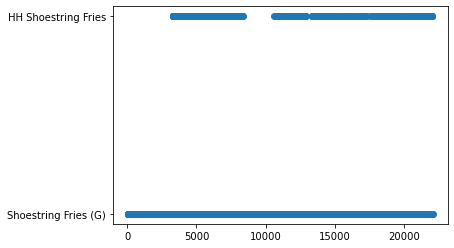

In [54]:
#filter rows of original data
filtered_label0 = orders[X_clustered == 3]

 
#plotting the results
plt.scatter(filtered_label0[:].index , filtered_label0[:].name)
plt.show()

In [ ]:
orders.restaurantid.value_counts()

1029    16451
121      3281
1034     2600
299      1748
1048       17
1040        9
110         3
Name: restaurantid, dtype: int64

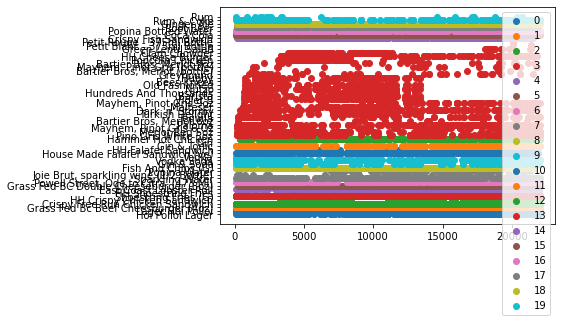

In [53]:
#Getting unique labels
 
u_labels = np.unique(X_clustered)
 
#plotting the results:
plt.Figure(figsize=[10,50])
for i in u_labels:
    plt.scatter(orders[X_clustered == i].index , orders[X_clustered == i].name, label = i )
plt.legend()
plt.show()

In [74]:
train_data.description

0                                                  750 ML 
1        8 oz grass-fed BC beef caramelized on flat top...
2        8oz boneless chicken leg marinated in buttermi...
3        4 oz grass-fed BC beef caramelized on flat top...
4                         Yogurt drink with special herbs.
                               ...                        
19898    Lettuce, cucumbers, tomatoes, and Indian-style...
19899    Fresh cucumbers and broiled potatoes in cold y...
19900                                  Sweet mango relish.
19901                          Two spiced lentil crackers.
19902    Mixed Indian pickles (mangoes, lemons, limes, ...
Name: description, Length: 19903, dtype: object

In [83]:
def get_list_ingredients(df):
    ''' Helper function to get the frequency of ingredients from a DataFrame'''
    
    possible_ingredients = {}
    def inc_dict(ing):
        if ing in possible_ingredients.keys():
            possible_ingredients[ing] += 1
            print(possible_ingredients[ing])
            return
        possible_ingredients[ing] = 1
    
    type_ = float
    
    # Compute the frequency of ingredients in a data frame
    train_data['description'].apply(lambda x: [inc_dict(ing) for ing in x])
    
    # Cast dict to list
    ing_data = np.array([[a[0], a[1]]for a in possible_ingredients.items()])
    ing_data[:,1] = (ing_data[:,1].astype(type_))
    
    label = 'Number of apparition'
    df_ing = pd.DataFrame(data={'description': ing_data[:, 0], label: ing_data[:, 1].astype(float)})
    return df_ing


In [ ]:
# Get the frequencies of all ingredients
ingredients = get_list_ingredients(train_data)
freqs = dict([tuple(x) for x in ingredients.values])

# Plot simple bar chart
ax= ingredients.sort_values(by='Number of apparition', ascending=False).head(20).plot(x='description', y='Number of apparition', kind='bar')
ax.set_title('Distribution of the ingredients')
b=ax.set_ylabel('Number of apparition')

In [75]:
ingredients

,description,Number of apparition
0,7,157.0
1,5,493.0
2,0,1068.0
3,,229054.0
4,M,1233.0
...,...,...
105,¢,1.0
106,\,2.0
107,],1.0
108,ü,2.0


In [ ]:
# Get the frequencies of all ingredients
ingredients = get_list_ingredients(df)
freqs = dict([tuple(x) for x in ingredients.values])

# Plot simple bar chart
ax= ingredients.sort_values(by='Number of apparition', ascending=False).head(20).plot(x='Ingredient', y='Number of apparition', kind='bar')
ax.set_title('Distribution of the ingredients')
b=ax.set_ylabel('Number of apparition')

### Clustering 

In [ ]:
train_data.head()

,id,name,description,photourl,tagsstring,rating,ratingcount,calories,fiber,carbohydrate,searchvector,isglobal,property,sku,type,tokenized,tokens
0,81456,"Mayhem, Pinot Gris (bottle)",750 ML,https://res.cloudinary.com/fooreco/image/uploa...,Alcohol,NaN,0,NaN,NaN,NaN,'alcohol':5 'bottl':4 'gris':3 'mayhem':1 'pin...,False,NaN,NaN,Liquor,[750 ml],750 ml
1,81439,Grass Fed BC Double Cheeseburger (8oz),8 oz grass-fed BC beef caramelized on flat top...,https://res.cloudinary.com/fooreco/image/uploa...,0,3.7,3,NaN,NaN,NaN,'8oz':6 'bc':3 'cheeseburg':5 'doubl':4 'fed':...,False,NaN,NaN,Main,"[8 oz grassfed bc beef caramelized, sliced rom...","8 oz grassfed bc beef caramelized,sliced roma ..."
2,81440,Crispy Free Run Chicken Sandwich,8oz boneless chicken leg marinated in buttermi...,https://res.cloudinary.com/fooreco/image/uploa...,Onions Chicken Honey Gluten,1.0,1,NaN,NaN,NaN,"'chicken':4,7 'crispi':1 'free':2 'gluten':9 '...",False,NaN,NaN,Main,"[8oz boneless chicken leg marinated, choosing ...","8oz boneless chicken leg marinated,choosing gf..."
3,81438,Grass Fed Bc Beef Cheesburger (4oz),4 oz grass-fed BC beef caramelized on flat top...,https://res.cloudinary.com/fooreco/image/uploa...,Beef Onions Tomato Gluten,2.7,3,NaN,NaN,NaN,"'4oz':6 'bc':3 'beef':4,7 'cheesburg':5 'fed':...",False,NaN,NaN,Main,"[4 oz grassfed bc beef caramelized, sliced rom...","4 oz grassfed bc beef caramelized,sliced roma ..."
4,313,Doogh (pitcher),Yogurt drink with special herbs.,NaN,Yogurt,NaN,0,NaN,NaN,NaN,'doogh':1 'pitcher':2 'yogurt':3,False,NaN,NaN,Drink,"[yogurt drink, special herbs]","yogurt drink,special herbs"


In [ ]:
#subset of the data
train_reduced = train_data.sample(n=5000)
train_reduced.shape

(5000, 17)

In [ ]:
count_matrix_reduced = counter.transform(train_reduced.tokens)

In [37]:
from sklearn.cluster import KMeans, DBSCAN

In [ ]:
kmeans = KMeans(
init="random",
n_clusters=500,
n_init=10,
max_iter=1000,
random_state=42)

In [ ]:
# fit to data array
kmeans.fit(count_matrix_reduced)

# The lowest SSE value
kmeans.inertia_

29308.09883514442

In [ ]:
# setting key-word arguments

kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 1000,
        "random_state": 42,}


# making a list of sum of squared errors for different cluster amounts (1-19)

sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(count_matrix_reduced)
    sse.append(kmeans.inertia_)

sse

[51878.49240000002,
 49709.26810997462,
 48688.59775426932,
 47545.35981387897,
 46925.510607664095,
 46507.89830996783,
 46331.27755454228,
 45827.924694460395,
 45610.93753842718,
 45178.5579811292,
 45081.92806141897,
 44534.134615509494,
 44240.78551989259,
 43902.53755124756,
 43722.72358059298,
 43632.85800991136,
 43401.33264833872,
 43275.316061883685,
 42972.625408174375]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

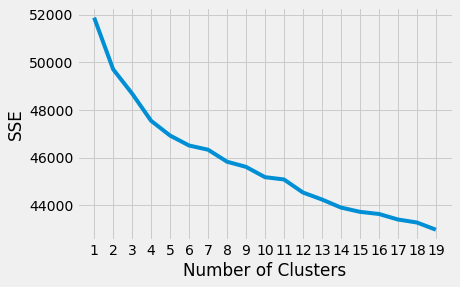

In [ ]:
# plotting the above info 

plt.style.use("fivethirtyeight")
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
# Creating a list of silhouette coefficients

silhouette_coefficients = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(count_matrix_reduced)
    score = silhouette_score(count_matrix_reduced, kmeans.labels_)
    silhouette_coefficients.append(score)

silhouette_coefficients

[0.20101321531819188,
 0.05853937654772239,
 0.059298726881011905,
 0.05544774369285615,
 0.045072666403557775,
 0.030282305674296513,
 0.0382429280911515,
 0.02414662203998417,
 0.04484834729703896,
 0.02286348616171906,
 0.024088189752064032,
 0.023021314935212395,
 0.02414192002498217,
 0.02244450072404686,
 0.021434093065925634,
 0.02293343427200681,
 0.022462619771941125,
 0.02310817349809465]

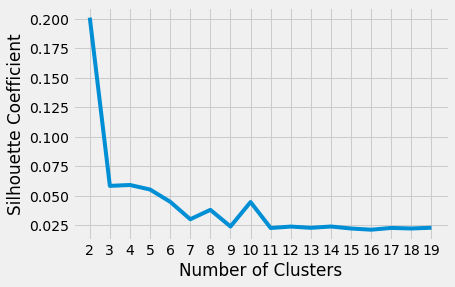

In [ ]:
# plotting the above 

plt.style.use("fivethirtyeight")
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [ ]:
#comparing silhouette scores for 2 algos

# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=200)
dbscan = DBSCAN(eps=1.4)

# Fit the algorithms to the features
kmeans.fit(count_matrix_reduced)
dbscan.fit(count_matrix_reduced)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(count_matrix_reduced, kmeans.labels_).round(2)
dbscan_silhouette = silhouette_score(count_matrix_reduced, dbscan.labels_).round (2)

# comapring the KMeans and DBscan silhouette scores
kmeans_silhouette, dbscan_silhouette

(0.02, -0.25)

In [ ]:
# using the fit and predict methods to generate clusters

km = KMeans(n_clusters=300)
X_clustered=km.fit_predict(count_matrix_reduced)

db = DBSCAN(eps=1.4, algorithm='auto')
X_clustered2 = db.fit_predict(count_matrix_reduced)

In [ ]:
train_data['cluster_1'] = X_clustered


/var/folders/pm/804wbvdx4lz30mqcr3mys38r0000gn/T/ipykernel_96778/3176517310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['cluster_1'] = X_clustered


In [ ]:
train_data['cluster_2'] = X_clustered2


/var/folders/pm/804wbvdx4lz30mqcr3mys38r0000gn/T/ipykernel_96778/4124583156.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['cluster_2'] = X_clustered2


In [ ]:
train_data.head()

,id,name,description,photourl,tagsstring,rating,ratingcount,calories,fiber,carbohydrate,searchvector,isglobal,property,sku,type,tokenized,tokens,cluster_1,cluster_2
0,81456,"Mayhem, Pinot Gris (bottle)",750 ML,https://res.cloudinary.com/fooreco/image/uploa...,Alcohol,NaN,0,NaN,NaN,NaN,'alcohol':5 'bottl':4 'gris':3 'mayhem':1 'pin...,False,NaN,NaN,Liquor,[750 ml],750 ml,14,-1
1,81439,Grass Fed BC Double Cheeseburger (8oz),8 oz grass-fed BC beef caramelized on flat top...,https://res.cloudinary.com/fooreco/image/uploa...,0,3.7,3,NaN,NaN,NaN,'8oz':6 'bc':3 'cheeseburg':5 'doubl':4 'fed':...,False,NaN,NaN,Main,"[8 oz grassfed bc beef caramelized, sliced rom...","8 oz grassfed bc beef caramelized,sliced roma ...",116,-1
2,81440,Crispy Free Run Chicken Sandwich,8oz boneless chicken leg marinated in buttermi...,https://res.cloudinary.com/fooreco/image/uploa...,Onions Chicken Honey Gluten,1.0,1,NaN,NaN,NaN,"'chicken':4,7 'crispi':1 'free':2 'gluten':9 '...",False,NaN,NaN,Main,"[8oz boneless chicken leg marinated, choosing ...","8oz boneless chicken leg marinated,choosing gf...",116,-1
3,81438,Grass Fed Bc Beef Cheesburger (4oz),4 oz grass-fed BC beef caramelized on flat top...,https://res.cloudinary.com/fooreco/image/uploa...,Beef Onions Tomato Gluten,2.7,3,NaN,NaN,NaN,"'4oz':6 'bc':3 'beef':4,7 'cheesburg':5 'fed':...",False,NaN,NaN,Main,"[4 oz grassfed bc beef caramelized, sliced rom...","4 oz grassfed bc beef caramelized,sliced roma ...",116,-1
4,313,Doogh (pitcher),Yogurt drink with special herbs.,NaN,Yogurt,NaN,0,NaN,NaN,NaN,'doogh':1 'pitcher':2 'yogurt':3,False,NaN,NaN,Drink,"[yogurt drink, special herbs]","yogurt drink,special herbs",160,-1


In [ ]:
train_data.shape

(19903, 19)

In [ ]:
train_data.cluster_1.value_counts().sort_values(ascending = False).head(30)

14     2017
73      440
65      339
110     313
262     305
169     277
99      269
62      254
42      239
152     236
39      235
227     233
237     232
256     231
137     227
19      219
189     211
177     206
75      201
270     197
13      195
258     195
140     182
56      172
196     171
251     170
259     166
87      165
81      161
267     161
Name: cluster_1, dtype: int64

In [45]:
import sklearn.decomposition
import matplotlib.colors
import sklearn.cluster as cluster

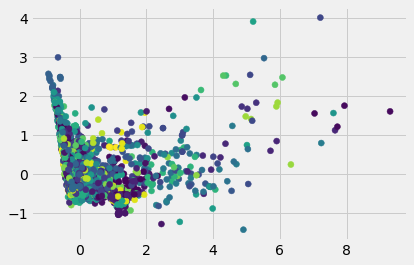

In [ ]:
# K Means algo
import sklearn.decomposition
import matplotlib.colors
import sklearn.cluster as cluster
# Make a variable called model. 
model= cluster.KMeans(n_clusters=200)
# Call a fit_predict() on X 
cluster_assignments = model.fit_predict(count_matrix_reduced)

# Use decomposition.PCA, and pass n_components=2 as parameter
pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(count_matrix_reduced))
plt.scatter(pc1, pc2, c=cluster_assignments.tolist())

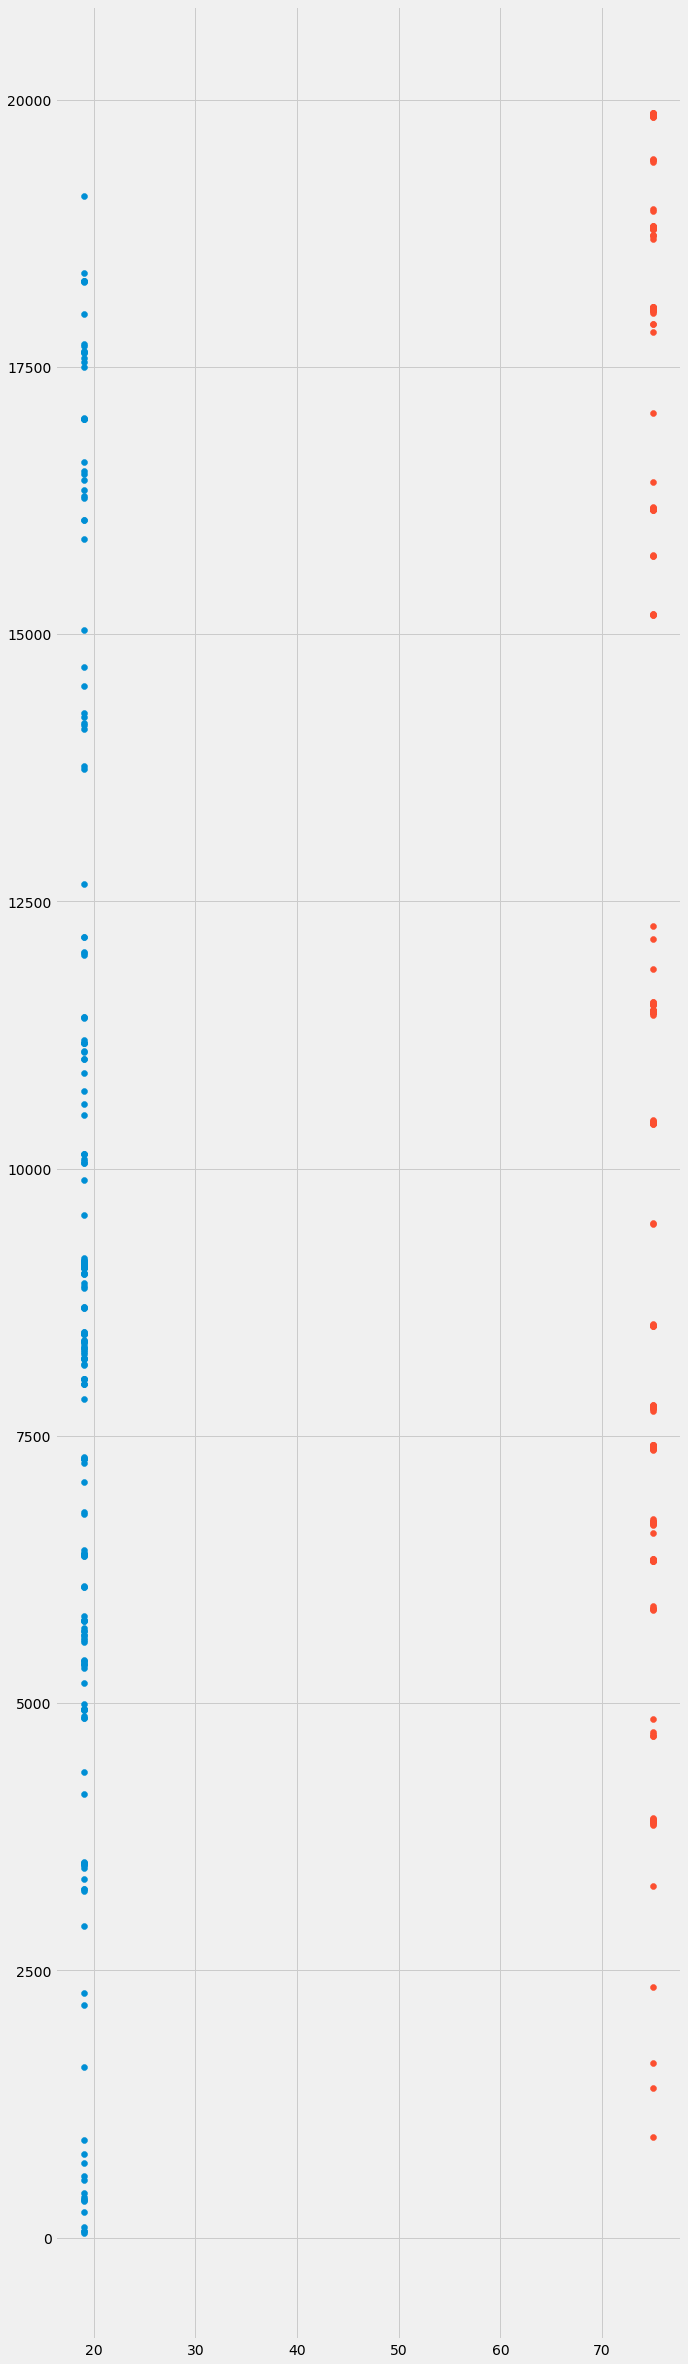

In [ ]:
#filter rows of original data
filtered_label = train_data[X_clustered == 19]
filtered_label_1 = train_data[X_clustered == 75]
 
#plotting the results
plt.figure(figsize=[10,40])
plt.scatter(filtered_label.iloc[:].cluster_1 , filtered_label.iloc[:].index)
plt.scatter(filtered_label_1.iloc[:].cluster_1 , filtered_label_1.iloc[:].index)
plt.show()

In [ ]:
filtered_label.iloc[:].index

Int64Index([    7,    21,   225,   249,   260,   429,   638,   913,   943,
              966,
            ...
            19566, 19567, 19591, 19592, 19593, 19594, 19664, 19669, 19702,
            19703],
           dtype='int64', length=313)

In [204]:
info_items = pd.read_csv('../data/itemsInfo.csv')
items = pd.read_csv('../data/items.csv')
orders = pd.read_csv('../data/full_data.csv')
items_full = pd.read_csv('../data/itemsInfo_full.csv')


/Users/nakisaabbasi/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [184]:
info_items.head(3)

,Id,Name,Description,PhotoUrl,TagsString,Rating,RatingCount,Calories,Fiber,Carbohydrate,SearchVector,IsGlobal,Property,Sku,Type
0,81465,Popina Bottled Water,NaN,https://res.cloudinary.com/fooreco/image/uploa...,NaN,NaN,0,NaN,NaN,NaN,'bottl':2 'popina':1 'water':3,False,NaN,NaN,Drink
1,81456,"Mayhem, Pinot Gris (bottle)",750 ML,https://res.cloudinary.com/fooreco/image/uploa...,Alcohol,NaN,0,NaN,NaN,NaN,'alcohol':5 'bottl':4 'gris':3 'mayhem':1 'pin...,False,NaN,NaN,Liquor
2,81457,"Bartier Bros, Merlot (bottle)",NaN,https://res.cloudinary.com/fooreco/image/uploa...,Alcohol,NaN,0,NaN,NaN,NaN,'alcohol':5 'bartier':1 'bottl':4 'bros':2 'me...,False,NaN,NaN,Liquor


In [185]:
items.head(3)

,Id,Price,MenuBookCategoryId,MenuBookId,AvailableDays,OrderIndex,IsAvailable,InfoId,ViewCount,DiscountId,IsHidden
0,8345,0.9,1150,240,NaN,0,True,8258,0,NaN,False
1,8346,7.0,1150,240,NaN,0,True,8259,0,NaN,False
2,2046,18.0,343,172,NaN,0,True,1959,0,NaN,False


In [186]:
orders.head(3)

,OrderId,UserId,RestaurantId,Date,Rating,Comments,Address,Count,ItemId,Price,ViewCount,Name,Description,SearchVector,Type
0,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,211,15.0,0.0,Tableside Spinach Salad,NaN,'almond':8 'babi':4 'bacon':11 'jack':10 'mont...,Main
1,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,218,27.0,0.0,King Crab,NaN,'blanc':9 'buerr':8 'caper':7 'char':3 'chilli...,Main
2,293,4,121,2020-05-13 01:20:59.267256,NaN,NaN,NaN,1,440,14.0,1097.0,Joojeh Kabab With Rice,One skewer of chicken breast marinated with yo...,'bbq':14 'chicken':11 'joojeh':1 'juic':9 'kab...,Main


In [205]:
items_full.head()

,Id,Price,ViewCount,Name,Description,SearchVector,Type
0,8345,0.9,0,Cookie,Freshly baked cookies. One order comes with on...,'cooki':1,Main
1,8346,7.0,0,12 Cookies,Freshly baked cookies. One order comes with tw...,'12':1 'cooki':2,Main
2,2046,18.0,0,Sausage Hash-n-eggs,NaN,'egg':5 'hash':3 'hash-n-egg':2 'n':4 'sausag':1,Main
3,2047,18.0,0,Ham Hash-n-eggs,NaN,'egg':5 'ham':1 'hash':3 'hash-n-egg':2 'n':4,Main
4,2048,18.0,0,Debakon Hash-n-eggs,DeBakon with hash-n-eggs.,'debakon':1 'egg':5 'hash':3 'hash-n-egg':2 'n':4,Main


In [188]:
item_id = orders.iloc[0].ItemId
item_id

211

In [190]:
item_name = orders.iloc[0].Name
item_name

'Tableside Spinach Salad'

In [202]:
infoId = items[items.Id == 82659].InfoId.values[0]
infoId

82536

In [203]:
items_info[items_info.Id == infoId]

,Id,Name,Description,PhotoUrl,TagsString,Rating,RatingCount,Calories,Fiber,Carbohydrate,SearchVector,IsGlobal,Property,Sku,Type
83350,82536,Shoestring Fries (G),NaN,https://res.cloudinary.com/fooreco/image/uploa...,Potatoes,5.0,2,NaN,NaN,NaN,'fri':2 'g':3 'potato':4 'shoestr':1,False,NaN,NaN,Main


In [206]:
items_full[items_full.Id == item_id]

,Id,Price,ViewCount,Name,Description,SearchVector,Type
2546,211,15.0,0,Tableside Spinach Salad,NaN,'almond':8 'babi':4 'bacon':11 'jack':10 'mont...,Main
